# Forecasting Energy Demand 

## Modeling
My approach treats the problem as a standard supervised regression task. Given a set of features – the time and weather information – we want to build a model that can predict the continuous target, energy consumption. The model is trained on the past historical energy consumption using the features and the target and then can be used to make predictions for future dates where only the features are known.

* Train/Test Split
* Scale all features using a min-max scaler
* Fit data with model
* Evaluate model


In [58]:
# Install xgboost in notebook instance
!conda install -y -c conda-forge xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.8.1

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [ ]:
# Install plotly in notebook instance
!conda install -c plotly plotly=4.4.1

In [85]:
# Import AWS and Sagemaker SDKs and get files access
import boto3
import io
from sagemaker import get_execution_role

role = get_execution_role()
bucket ='sagemaker-data-energy-demand'

In [121]:
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


# XGBoost 
import xgboost as xgb

In [102]:
# Import data 

CITY = 'LosAngeles'
train_key = 'dataframes/%s/train/data_train.csv' % CITY
validation_key = 'dataframes/%s/test/data_validation.csv' % CITY

train_location = 's3://{}/{}'.format(bucket, train_key)
validation_location = 's3://{}/{}'.format(bucket, validation_key)

df_train = pd.read_csv(train_location, index_col='datetime')
df_validation = pd.read_csv(validation_location, index_col='datetime')

In [103]:
def data_sppliter(df, label):
    cols = list(df.columns)
    cols.remove(label)
    X = df[cols]
    y = df[label]
    return X, y

X_train, y_train = data_sppliter(df_train, label='demand(t)')
X_validation, y_validation = data_sppliter(df_validation, label='demand(t)')

In [108]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_validation = pd.DataFrame(X_validation_scaled, columns=X_validation.columns, index=X_validation.index)

## Create XGBoost Model

In [109]:
# XGBoost Training Parameter Reference: 
# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md

regressor = xgb.XGBRegressor(max_depth=5, n_estimators=150)

In [110]:
regressor.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_validation, y_validation)]) 

[06:38:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:2993.35	validation_1-rmse:2531.98
[1]	validation_0-rmse:2694.86	validation_1-rmse:2278
[2]	validation_0-rmse:2426.23	validation_1-rmse:2048.79
[3]	validation_0-rmse:2184.39	validation_1-rmse:1841.82
[4]	validation_0-rmse:1966.78	validation_1-rmse:1658.41
[5]	validation_0-rmse:1770.93	validation_1-rmse:1491.78
[6]	validation_0-rmse:1594.63	validation_1-rmse:1341.16
[7]	validation_0-rmse:1436.05	validation_1-rmse:1206.14
[8]	validation_0-rmse:1293.27	validation_1-rmse:1084.06
[9]	validation_0-rmse:1164.73	validation_1-rmse:975.789
[10]	validation_0-rmse:1049.07	validation_1-rmse:876.904
[11]	validation_0-rmse:945.004	validation_1-rmse:788.866
[12]	validation_0-rmse:851.366	validation_1-rmse:709.924
[13]	validation_0-rmse:767.12	validation_1-rmse:638.169
[14]	validation_0-rmse:691.339

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=1, verbosity=1)

In [111]:
eval_result = regressor.evals_result()
training_rounds = range(len(eval_result['validation_0']['rmse']))

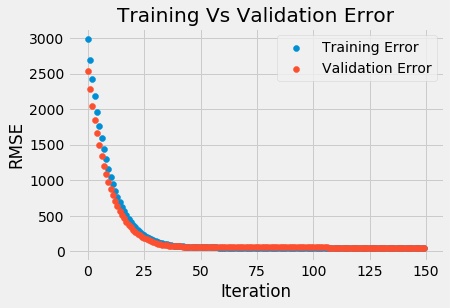

In [112]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

### Feature importance plot
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.
We can see that the hour was most commonly used to split trees alongside day of year and day of week, while weather features has low importance.

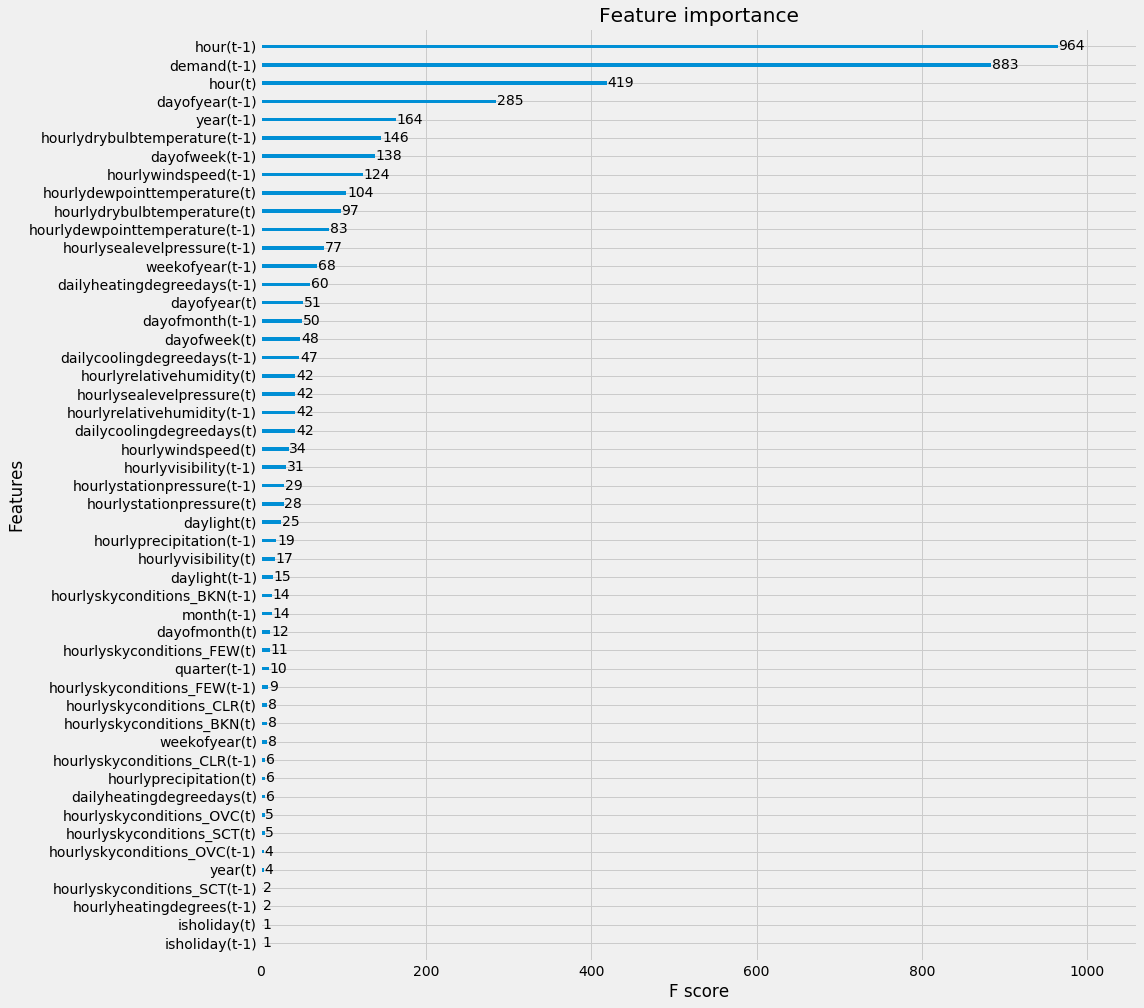

In [113]:
fig, ax = plt.subplots(figsize=(14, 16))
xgb.plot_importance(regressor, ax=ax)
plt.show()

## Forecast on Validation Set

In [83]:
df_validation['XGBoost_demand_prediction'] = regressor.predict(X_validation)
df_all = pd.concat([df_train, df_validation], sort=False)

In [84]:
regressor.score(X_validation, y_validation)

0.9725209724097479

In [37]:
df_validation.head()

,demand(t),dailycoolingdegreedays(t-1),dailyheatingdegreedays(t-1),hourlydewpointtemperature(t-1),hourlydrybulbtemperature(t-1),hourlyprecipitation(t-1),hourlyrelativehumidity(t-1),hourlysealevelpressure(t-1),hourlystationpressure(t-1),hourlyvisibility(t-1),...,quarter(t),month(t),year(t),dayofyear(t),dayofmonth(t),weekofyear(t),isbusinessday(t),isholiday(t),daylight(t),XGBoost_demand_prediction
datetime,,,,,,,,,,,,,,,,,,,,,
2019-12-27 21:00:00+00:00,2862.0,0.0,12.0,32.0,56.0,0.0,40.0,30.00,29.65,10.0,...,4.0,12.0,2019.0,361.0,27.0,52.0,1.0,0.0,0.0,2863.627197
2019-12-27 22:00:00+00:00,2859.0,0.0,12.0,31.0,54.0,0.0,42.0,30.01,29.66,10.0,...,4.0,12.0,2019.0,361.0,27.0,52.0,1.0,0.0,0.0,2848.161133
2019-12-27 23:00:00+00:00,2907.0,0.0,12.0,31.0,64.0,0.0,42.0,29.96,29.61,10.0,...,4.0,12.0,2019.0,362.0,28.0,52.0,0.0,0.0,0.0,2889.705078
2019-12-28 00:00:00+00:00,3101.0,0.0,10.0,33.0,52.0,0.0,49.0,30.03,29.68,10.0,...,4.0,12.0,2019.0,362.0,28.0,52.0,0.0,0.0,0.0,3094.978516
2019-12-28 01:00:00+00:00,3406.0,0.0,10.0,33.0,49.0,0.0,55.0,30.03,29.69,10.0,...,4.0,12.0,2019.0,362.0,28.0,52.0,0.0,0.0,0.0,3397.804688


In [ ]:
df_all.tail()

In [ ]:
# Create traces
fig = go.Figure()
fig.add_trace(go.Scattergl(y=df_all['demand(t)'], x=df_all.index,
                    mode='markers',
                    name='TRAINING SET'))
fig.add_trace(go.Scattergl(y=df_all['XGBoost_demand_prediction'], x=df_all.index,
                    mode='lines',
                    name='PREDICT SET'))
fig.update_layout(title='Los Angeles - Forecast On Test',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

### Zooming-in at first month of predictions

In [ ]:
# Create traces
first_month = df_all.head(720)
fig = go.Figure()
fig.add_trace(go.Scattergl(y=first_month['demand(t)'], x=first_month.index,
                    mode='lines',
                    name='TRAINING SET'))
fig.add_trace(go.Scattergl(y=first_month['XGBoost_demand_prediction'], x=first_month.index,
                    mode='lines',
                    name='TEST SET'))
fig.update_layout(title='Forecast vs Actuals - First Month',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

In [ ]:
# Create traces
first_month = df_all.head(168)
fig = go.Figure()
fig.add_trace(go.Scattergl(y=first_month['demand(t)'], x=first_month.index,
                    mode='markers',
                    name='TEST SET'))
fig.add_trace(go.Scattergl(y=first_month['XGBoost_demand_prediction'], x=first_month.index,
                    mode='lines',
                    name='PREDICT SET'))
fig.update_layout(title='Forecast vs Actuals - First Month',
                   xaxis_title='Date',
                   yaxis_title='Electricity Demand [MWh]')
fig.show()

In [ ]:
df_all.tail()

### Error Metrics On Test Set

In [38]:
rmse = mean_squared_error(y_true=df_validation['demand(t)'],
                   y_pred=df_validation['XGBoost_demand_prediction'])

mae = mean_absolute_error(y_true=df_validation['demand(t)'],
                   y_pred=df_validation['XGBoost_demand_prediction'])

def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_true=df_validation['demand(t)'],
                   y_pred=df_validation['XGBoost_demand_prediction'])

print(rmse)
print(mae)
print(mape)

2392.740054571893
32.64346203579467
1.1412912519605887


### Look at Worst and Best Predicted Days

In [39]:
df_validation['error'] = df_validation['demand(t)'] - df_validation['XGBoost_demand_prediction']
df_validation['abs_error'] = df_validation['error'].apply(np.abs)
error_by_day = df_validation.groupby(['year(t)','month(t)','dayofmonth(t)']) \
    .mean()[['demand(t)','XGBoost_demand_prediction','error','abs_error']]

In [40]:
# Worst predicted days
error_by_day.sort_values('error', ascending=True).head(10)

demand(t)  XGBoost_demand_prediction  \
year(t) month(t) dayofmonth(t)                                           
2020.0  1.0      7.0            2824.541667                2841.986572   
                 2.0            2686.791667                2704.138184   
                 1.0            2708.000000                2724.679443   
                 6.0            2753.958333                2769.376465   
                 8.0            2825.041667                2836.935059   
                 5.0            2648.125000                2658.676758   
                 11.0           2772.173913                2781.679688   
                 10.0           2907.750000                2916.009521   
                 9.0            2862.125000                2866.506348   
                 3.0            2861.500000                2865.112305   

                                    error  abs_error  
year(t) month(t) dayofmonth(t)                        
2020.0  1.0      7.0           -17.444987  26.863200  
                 2.0           -17.346527  42.018972  
                 1.0           -16.679545  50.822428  
                 6.0           -15.418172  27.648946  
                 8.0           -11.893463  30.095388  
                 5.0           -10.551870  53.807037  
                 11.0           -9.505817  25.110797  
                 10.0           -8.259521  20.571106  
                 9.0            -4.381226  24.653727  
                 3.0            -3.612183  42.374959

In [41]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

demand(t)  XGBoost_demand_prediction  \
year(t) month(t) dayofmonth(t)                                           
2019.0  12.0     27.0           2860.500000                2855.894043   
                 28.0           2843.958333                2844.208008   
2020.0  1.0      10.0           2907.750000                2916.009521   
                 9.0            2862.125000                2866.506348   
                 11.0           2772.173913                2781.679688   
2019.0  12.0     30.0           2866.708333                2850.074951   
2020.0  1.0      7.0            2824.541667                2841.986572   
                 6.0            2753.958333                2769.376465   
2019.0  12.0     29.0           2721.791667                2714.310791   
2020.0  1.0      8.0            2825.041667                2836.935059   

                                    error  abs_error  
year(t) month(t) dayofmonth(t)                        
2019.0  12.0     27.0            4.605835   6.233032  
                 28.0           -0.249725  17.437124  
2020.0  1.0      10.0           -8.259521  20.571106  
                 9.0            -4.381226  24.653727  
                 11.0           -9.505817  25.110797  
2019.0  12.0     30.0           16.633413  25.865794  
2020.0  1.0      7.0           -17.444987  26.863200  
                 6.0           -15.418172  27.648946  
2019.0  12.0     29.0            7.480927  28.579234  
2020.0  1.0      8.0           -11.893463  30.095388

In [42]:
df_xgboost = df_validation[['XGBoost_demand_prediction']].copy()

In [24]:
df_xgboost.tail()

,XGBoost_demand_prediction
datetime,
2020-01-11 17:00:00+00:00,2806.136475
2020-01-11 18:00:00+00:00,2793.887451
2020-01-11 19:00:00+00:00,2760.680664
2020-01-11 20:00:00+00:00,2712.391113
2020-01-11 21:00:00+00:00,2705.773438


In [ ]:
# Define splits for cross validating model
kf = KFold(n_splits=5, shuffle=True, random_state=40)

# xgb_param_grid = {
#     'max_depth': [5, 7, 9],
#     'learning_rate': [0.1],
#     'n_estimators': [500],
#     'colsample_bytree':[0.5,0.75],
#     'colsample_bylevel':[0.25,0.5],
#     'reg_alpha':[0.7,0.9],
#     'reg_lambda':[0.1,0.3]
    
# }

# xgb_gridsearch = GridSearchCV(xgb.XGBRegressor(),
#                           xgb_param_grid,
#                           cv=kf,
#                           n_jobs=-1,
#                           scoring='r2')
# xgb_gridsearch.fit(X_train, y_train)

In [ ]:
# xgb_model_cv = xgb_gridsearch.best_estimator_
# y_pred_xgb_grid = xgb_model_cv.predict(X_validation)

In [ ]:
# # Evaluate model performance
# print('XGBoost model on training data R^2: {:f}'.format(
#     regressor.score(X_train, y_train)))
# print('XGBoost model on validation data R^2: {:f}'.format(
#     regressor.score(X_validation, y_validation)))

# print('Grid Search XGBoost model on training data R^2: {:f}'.format(
#     xgb_model_cv.score(X_train, y_train)))
# print('Grid Search XGBoost model on validation data R^2: {:f}'.format(
#     xgb_model_cv.score(X_validation, y_validation)))

In [ ]:
# df_validation['GridSearchXGBoost_demand_prediction'] = y_pred_xgb_grid
# df_gridsearch = df_validation[['GridSearchXGBoost_demand_prediction']].copy()

In [115]:
# save as csv file to continue in another notebook
xgb_buffer = io.StringIO()
s3_resource = boto3.resource('s3')
key = 'predict/%s/pred_xgboost.csv' % CITY

df_xgboost.to_csv(xgb_buffer, compression=None)
s3_resource.Object(bucket, key).put(Body=xgb_buffer.getvalue())

{'ResponseMetadata': {'RequestId': '517CE9DE6AEF3A93',
  'HostId': 'lHo7dfPHp4QHRLmuh/5vlJFmi1dbCpQ0lWOX8Y+87Rs2LT0L0q1GI09ED5T6G5T9nSSGNuO7fm4=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'lHo7dfPHp4QHRLmuh/5vlJFmi1dbCpQ0lWOX8Y+87Rs2LT0L0q1GI09ED5T6G5T9nSSGNuO7fm4=',
   'x-amz-request-id': '517CE9DE6AEF3A93',
   'date': 'Thu, 16 Jan 2020 14:25:29 GMT',
   'etag': '"2c20501d8c6c68aedf32372e093f80c8"',
   'content-length': '0',
   'server': 'AmazonS3'},
  'RetryAttempts': 0},
 'ETag': '"2c20501d8c6c68aedf32372e093f80c8"'}

In [ ]:
# # save as csv file to continue in another notebook
# gridsearch_buffer = io.StringIO()
# s3_resource = boto3.resource('s3')
# key = 'predict/%s/pred_gridsearchxgb.csv' % CITY

# df_gridsearch.to_csv(gridsearch_buffer, compression=None)
# s3_resource.Object(bucket, key).put(Body=gridsearch_buffer.getvalue())

In [44]:
df_xgboost.tail()

,XGBoost_demand_prediction
datetime,
2020-01-11 17:00:00+00:00,2797.402832
2020-01-11 18:00:00+00:00,2795.495605
2020-01-11 19:00:00+00:00,2768.295410
2020-01-11 20:00:00+00:00,2709.892334
2020-01-11 21:00:00+00:00,2693.861572
